In [5]:
import numpy as np
import pickle
import os
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from scipy import stats

# Data preparation

In [6]:
train_annotation_path = '/nas/database/Big5/gt/annotation_training.pkl'
val_annotation_path = '/nas/database/Big5/gt/annotation_validation.pkl'
test_annotation_path = '/nas/database/Big5/gt/annotation_test.pkl'

train_data_path = '/nas/project_data/B1_Behavior/hakim/FI/ME_AU_feature/train'
val_data_path = '/nas/project_data/B1_Behavior/hakim/FI/ME_AU_feature/val'
test_data_path = '/nas/project_data/B1_Behavior/hakim/FI/ME_AU_feature/test'

with open(train_annotation_path, 'rb') as f:
    train_annotation = pickle.load(f, encoding='latin1')
train_videos = list(train_annotation['extraversion'].keys())

with open(val_annotation_path, 'rb') as f:
    val_annotation = pickle.load(f, encoding='latin1')
val_videos = list(val_annotation['extraversion'].keys())

with open(test_annotation_path, 'rb') as f:
    test_annotation = pickle.load(f, encoding='latin1')
test_videos = list(test_annotation['extraversion'].keys())

with open('/nas/project_data/B1_Behavior/hakim/FI/ME_AU_feature/mean_std.npy', 'rb') as f:
    mean_std_au = np.load(f)
    

train_features = []
train_labels = []
val_features = []
val_labels = []
test_features = []
test_labels = []

In [7]:
for i, video in enumerate(train_videos):
    video_name = video.rsplit(".")[0] + '.' + video.rsplit(".")[1]
    input_name = video_name + '.npy'
    input_path = os.path.join(train_data_path, input_name)
    with open(input_path, 'rb') as f:
        au = np.load(f)
        au = (au - mean_std_au[:,0]) / mean_std_au[:,1]
        if au.shape[0] < 450:
            au = np.pad(au, ((0,450-au.shape[0]),(0,0)), 'constant', constant_values=0)

    # Include only 11 AU
    au = au[:,:11]
    train_features.append(au)
    
    label = np.array([train_annotation['extraversion'][video],
                     train_annotation['neuroticism'][video],
                     train_annotation['agreeableness'][video],
                     train_annotation['conscientiousness'][video],
                     train_annotation['openness'][video]])
    train_labels.append(label)
    
for i, video in enumerate(val_videos):
    video_name = video.rsplit(".")[0] + '.' + video.rsplit(".")[1]
    input_name = video_name + '.npy'
    input_path = os.path.join(val_data_path, input_name)
    with open(input_path, 'rb') as f:
        au = np.load(f)
        au = (au - mean_std_au[:,0]) / mean_std_au[:,1]
        if au.shape[0] < 450:
            au = np.pad(au, ((0,450-au.shape[0]),(0,0)), 'constant', constant_values=0)
    
    # Include only 11 AU
    au = au[:,:11]
    val_features.append(au)
    
    label = np.array([val_annotation['extraversion'][video],
                     val_annotation['neuroticism'][video],
                     val_annotation['agreeableness'][video],
                     val_annotation['conscientiousness'][video],
                     val_annotation['openness'][video]])
    val_labels.append(label)
    
for i, video in enumerate(test_videos):
    video_name = video.rsplit(".")[0] + '.' + video.rsplit(".")[1]
    input_name = video_name + '.npy'
    input_path = os.path.join(test_data_path, input_name)
    with open(input_path, 'rb') as f:
        au = np.load(f)
        au = (au - mean_std_au[:,0]) / mean_std_au[:,1]
        if au.shape[0] < 450:
            au = np.pad(au, ((0,450-au.shape[0]),(0,0)), 'constant', constant_values=0)
    # Include only 11 AU
    au = au[:,:11]
    test_features.append(au)
    
    label = np.array([test_annotation['extraversion'][video],
                     test_annotation['neuroticism'][video],
                     test_annotation['agreeableness'][video],
                     test_annotation['conscientiousness'][video],
                     test_annotation['openness'][video]])
    test_labels.append(label)

In [8]:
train_features = torch.Tensor(np.array(train_features))
train_labels = torch.Tensor(np.array(train_labels))
val_features = torch.Tensor(np.array(val_features))
val_labels = torch.Tensor(np.array(val_labels))
test_features = torch.Tensor(np.array(test_features))
test_labels = torch.Tensor(np.array(test_labels))

BATCH_SIZE = 256
train = TensorDataset(train_features, train_labels)
val = TensorDataset(val_features, val_labels)
test = TensorDataset(test_features, test_labels)
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# Model

In [9]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [10]:
class GRU(torch.nn.Module):
    def __init__(self, input_size, hidden_size, bidirectional, output_dim, dropout, num_layers, batch_size):
        super(GRU, self).__init__()
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.dropout = dropout
        self.gru = torch.nn.GRU(input_size=self.input_size, 
                                hidden_size=self.hidden_size,
                                num_layers=self.num_layers,
                                dropout=self.dropout,
                                bidirectional=bidirectional,
                                batch_first=True)
        self.fc = torch.nn.Linear(hidden_size if not bidirectional else hidden_size * 2, output_dim)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        out, h = self.gru(x)
        out = self.relu(out[:,-1,:])
        out = self.fc(out)
        out = self.sigmoid(out)
        return out

# Training

In [11]:
def train(model, train_loader, val_loader, epochs, patience=5):
    train_losses = []
    val_losses = []
    val_maes = []

    the_last_loss = 1e6
    trigger_times = 0

    for epoch in range(0, epochs):
        model.train()
        batch_losses = []

        for inputs, targets in train_loader:
            preds = model(inputs.to(device))
            loss = loss_fn(preds, targets.to(device))
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)
            optimizer.step()
            batch_losses.append(loss.item())

        train_loss = np.mean(batch_losses)
        train_losses.append(train_loss)

        model.eval()
        with torch.no_grad():
            batch_val_losses = []
            batch_val_mae = []

            for inputs, targets in val_loader:
                model.eval()
                preds = model(inputs.to(device))
                loss = loss_fn(preds, targets.to(device))
                batch_val_losses.append(loss.item())
                val_mae = mae(preds, targets.to(device))
                batch_val_mae.append(val_mae.item())
            val_loss = np.mean(batch_val_losses)
            val_mae = np.mean(batch_val_mae)
            scheduler.step(val_loss)
            val_losses.append(val_loss)
            val_maes.append(val_mae)

        print(f'Epoch {epoch} - train loss: {train_loss:.5f} - val loss: {val_loss:.5f} - val 1-mae: {(1-val_mae):.5f}')
        
        # early stopping
        if val_loss > the_last_loss:
            trigger_times += 1
            print('Trigger Times:', trigger_times)
            if trigger_times >= patience:
                print('Early Stopping!')
                break
        else:
            print('Trigger Times: 0')
            trigger_times = 0
        the_last_loss = val_loss
            
    return train_losses, val_losses, val_maes

In [13]:
model = GRU(input_size=11, 
                  hidden_size=256, 
                  bidirectional=True, 
                  output_dim=5, 
                  dropout=0.2, 
                  num_layers=2, 
                  batch_size=BATCH_SIZE)
model.to(device)

LR = 0.00001
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
loss_fn = torch.nn.MSELoss()
mae = torch.nn.L1Loss()

In [14]:
train_losses, val_losses, val_maes = train(model, train_loader, val_loader, epochs=50, patience=5)

Epoch 0 - train loss: 0.02390277061773383 - val loss: 0.02290728156055723 - val 1-mae: 0.8776378195200648
Trigger Times: 0
Epoch 1 - train loss: 0.023670461514721745 - val loss: 0.02234166647706713 - val 1-mae: 0.8790697434118816
Trigger Times: 0
Epoch 2 - train loss: 0.02350788239551627 - val loss: 0.022540293101753508 - val 1-mae: 0.8788479396275112
Trigger Times: 1
Epoch 3 - train loss: 0.023315519580374592 - val loss: 0.022505242909703935 - val 1-mae: 0.8789306740675654
Trigger Times: 0
Epoch 4 - train loss: 0.023182601060556328 - val loss: 0.021787494687097415 - val 1-mae: 0.8808903076819011
Trigger Times: 0
Epoch 5 - train loss: 0.023051281500121822 - val loss: 0.021757788690073148 - val 1-mae: 0.8812279009393283
Trigger Times: 0
Epoch 6 - train loss: 0.022851484625235848 - val loss: 0.021234946325421333 - val 1-mae: 0.882605757032122
Trigger Times: 0
Epoch 7 - train loss: 0.022624314722159634 - val loss: 0.02160370190228735 - val 1-mae: 0.8816473239234516
Trigger Times: 1
Epoch 

# Plot

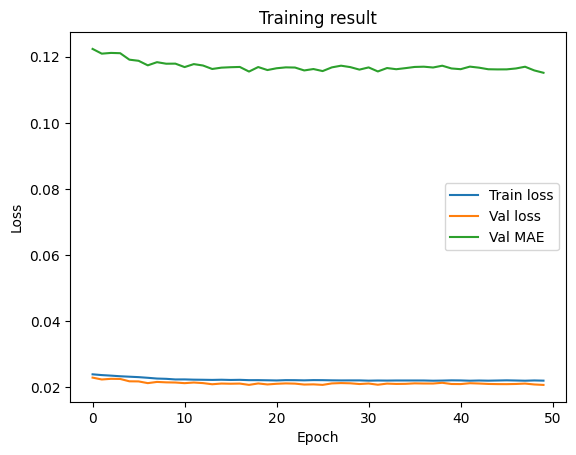

In [15]:
fig, ax = plt.subplots()
ax.plot(train_losses, label='Train loss')
ax.plot(val_losses, label='Val loss')
ax.plot(val_maes, label='Val MAE')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.title("Training result")
plt.legend()

# Testing

In [17]:
def test(model, test_loader):
    mae = torch.nn.L1Loss()
    predictions = np.array([])
    labels = np.array([])
    model.eval()
    with torch.no_grad():
        batch_loss_ext = []
        batch_loss_neu = []
        batch_loss_agr = []
        batch_loss_con = []
        batch_loss_ope = []

        for inputs, targets in test_loader:
            batch_preds = model(inputs.to(device))
            loss_ext = mae(batch_preds[:,0], targets[:,0].to(device))
            loss_neu = mae(batch_preds[:,1], targets[:,1].to(device))
            loss_agr = mae(batch_preds[:,2], targets[:,2].to(device))
            loss_con = mae(batch_preds[:,3], targets[:,3].to(device))
            loss_ope = mae(batch_preds[:,4], targets[:,4].to(device))
            batch_loss_ext.append(loss_ext.item())
            batch_loss_neu.append(loss_neu.item())
            batch_loss_agr.append(loss_agr.item())
            batch_loss_con.append(loss_con.item())
            batch_loss_ope.append(loss_ope.item())
            predictions = np.vstack((predictions, batch_preds.cpu())) if len(predictions) != 0 else batch_preds.cpu()
            labels = np.vstack((labels, targets.cpu())) if len(labels) != 0 else targets.cpu()

        loss_ext = 1 - np.mean(batch_loss_ext)
        loss_neu = 1 - np.mean(batch_loss_neu)
        loss_agr = 1 - np.mean(batch_loss_agr)
        loss_con = 1 - np.mean(batch_loss_con)
        loss_ope = 1 - np.mean(batch_loss_ope)
        loss = (loss_ext + loss_neu + loss_agr + loss_con + loss_ope) / 5

        print(f'1-MAE: {loss:.4f}')
        print(f'1-MAE O: {loss_ope:.4f}')
        print(f'1-MAE C: {loss_con:.4f}')
        print(f'1-MAE E: {loss_ext:.4f}')
        print(f'1-MAE A: {loss_agr:.4f}')
        print(f'1-MAE N: {loss_neu:.4f}')
        
        spearman_r_ext = stats.spearmanr(predictions[:,0], labels[:,0])
        spearman_r_neu = stats.spearmanr(predictions[:,1], labels[:,1])
        spearman_r_agr = stats.spearmanr(predictions[:,2], labels[:,2])
        spearman_r_con = stats.spearmanr(predictions[:,3], labels[:,3])
        spearman_r_ope = stats.spearmanr(predictions[:,4], labels[:,4])
        print(f'O - R: {spearman_r_ope[0]:.3f} - p: {spearman_r_ope[1]:.3f}')
        print(f'C - R: {spearman_r_con[0]:.3f} - p: {spearman_r_con[1]:.3f}')
        print(f'E - R: {spearman_r_ext[0]:.3f} - p: {spearman_r_ext[1]:.3f}')
        print(f'A - R: {spearman_r_agr[0]:.3f} - p: {spearman_r_agr[1]:.3f}')
        print(f'N - R: {spearman_r_neu[0]:.3f} - p: {spearman_r_neu[1]:.3f}')

In [18]:
test(model, test_loader)

1-MAE: 0.8821
1-MAE O: 0.8841
1-MAE C: 0.8761
1-MAE E: 0.8787
1-MAE A: 0.8935
1-MAE N: 0.8782
O - R: 0.050 - p: 0.034
C - R: 0.062 - p: 0.009
E - R: 0.064 - p: 0.007
A - R: 0.023 - p: 0.339
N - R: 0.063 - p: 0.008


In [19]:
prior = test_labels.mean(axis=0)
test_prior = torch.from_numpy(np.repeat(np.expand_dims(prior, axis=0), 2000, axis=0))
value = mae(test_prior, test_labels)
print('baseline prior 1-mae:', 1-value.item())

baseline prior 1-mae: 0.8814377188682556
